In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint 
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [2]:
#plt.rcParams['figure.figsize'] = [6.32, 5.11]
#plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'

In [4]:
L = 40
temp_val = np.arange(0.25, 4.0001, 0.25)
temp_samples = 10000
total_samples = temp_samples * temp_val.shape[0]
test_size = 0.1
val_size = 0.2

In [5]:
split_tc = False

In [6]:
data = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All.pkl','rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(float)
data[np.where(data==0)]=-1

labels = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))

In [7]:
first_tc = np.where(temp_val <= 2.)[0][-1] * temp_samples
last_tc = np.where(temp_val >= 3.)[0][1] * temp_samples

In [8]:
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [9]:
if split_tc:
    
    X_ordered = data[:first_tc, :]
    Y_ordered = np.column_stack((labels[:first_tc], temp_labels[:first_tc]))

    X_critical = data[first_tc:last_tc, :]
    Y_critical = np.column_stack((labels[first_tc:last_tc], temp_labels[first_tc:last_tc]))

    X_disordered = data[last_tc:, :]
    Y_disordered = np.column_stack((labels[last_tc:], temp_labels[last_tc:]))

    X = np.concatenate((X_ordered, X_disordered))
    Y = np.concatenate((Y_ordered, Y_disordered))
    
    del X_ordered, Y_ordered, X_disordered, Y_disordered, data, labels
    
else:
    
    X = data
    Y = np.column_stack((labels, temp_labels))
    
    del data, labels

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], L, L, 1))
X_test = np.reshape(X_test, (X_test.shape[0], L, L, 1))
X_val = np.reshape(X_val, (X_val.shape[0], L, L, 1))

In [25]:
checkpointer = ModelCheckpoint(filepath="/home/ronaldo/best_weights.hdf5", 
                               
                               verbose=1, 
                               )

In [13]:
model = Sequential()

model.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(L, L, 1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
          
model.add(Dropout(0.5))
          
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [26]:
history = model.fit(X_train, Y_train[:, 0], validation_split=0.1,batch_size=128, epochs=2, callbacks=[checkpointer])

Train on 103680 samples, validate on 11520 samples
Epoch 1/2
103680/103680 [==============================] - 5s 53us/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0127 - val_accuracy: 0.9953

Epoch 00001: saving model to /home/ronaldo/best_weights.hdf5
Epoch 2/2
103680/103680 [==============================] - 5s 53us/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0052 - val_accuracy: 0.9984

Epoch 00002: saving model to /home/ronaldo/best_weights.hdf5


In [17]:
score = model.evaluate(X_test, Y_test[:, 0], verbose=0)

In [18]:
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 0.9973 
Test loss: 0.0079


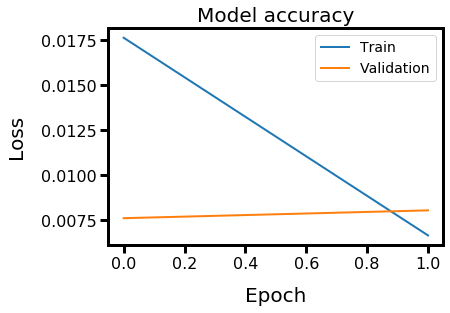

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

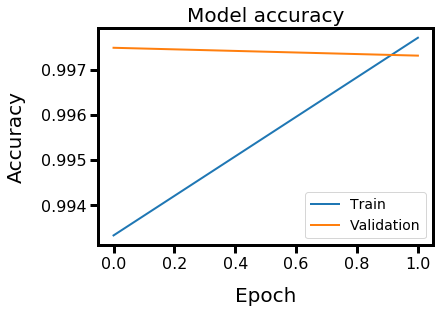

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [21]:
res_test = model.predict(X_test)

In [22]:
f_tc = int(first_tc / temp_samples)
l_tc = int(last_tc / temp_samples)

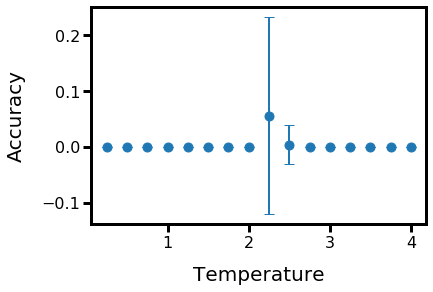

In [23]:
acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    aux = res_test[pos, 0] - Y_test[pos, 0]
    acc[idx] = np.mean(np.abs(aux))
    acc_std[idx] = np.std(np.abs(aux))

    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

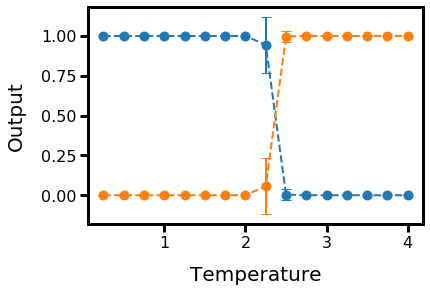

In [24]:
#%matplotlib notebook
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
       
    pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
    output_mean[idx] = np.mean(res_test[pos])
    output_std[idx] = np.std(res_test[pos])
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()

In [32]:
tf.keras.classifier.load_weights('/home/ronaldo/best_weights.hdf5')

AttributeError: module 'tensorflow.python.keras.api._v1.keras' has no attribute 'classifier'

In [30]:
model.save('my_model.h5') 

In [47]:
layer = model.layers[0]

# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

conv2d_1 (3, 3, 1, 10)


In [73]:
filters = (filters - filters.min()) / (filters.max() - filters.min())

In [79]:
plt.imshow?

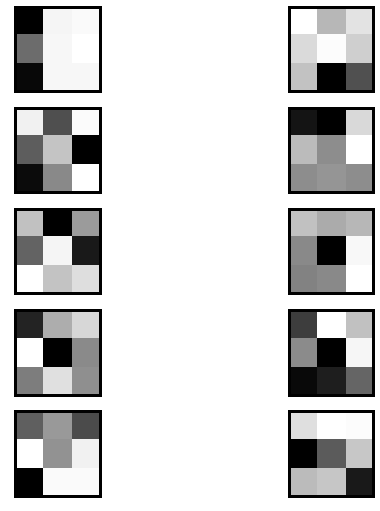

In [85]:
n_filters = filters.shape[3]

plt.figure(figsize=[9,9])

for idx in range(n_filters):
    
    f = filters[:, :, 0, idx]
    
    axis = plt.subplot(5, 2, idx+1)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.imshow(f, cmap='Greys')

plt.show()

In [88]:
layer.output

<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 38, 38, 10) dtype=float32>

In [92]:
from keras.models import Model
model2 = Model(inputs=model.inputs, outputs=layer.output)

In [99]:
predict = model2.predict(X_train)

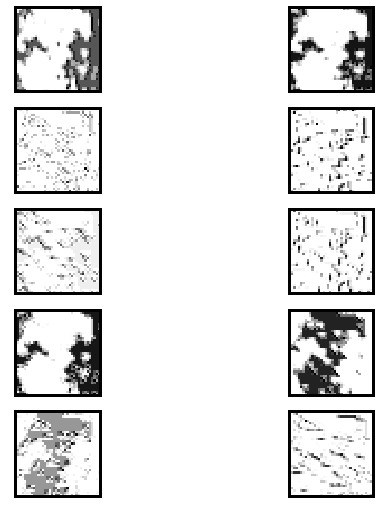

In [121]:
predict[44,:,:,0]

plt.figure(figsize=[9,9])

for idx in range(n_filters):
    
    f = predict[44, :, :, idx]
    
    axis = plt.subplot(5, 2, idx+1)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.imshow(f, cmap='Greys')
    
plt.show()

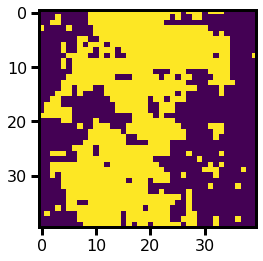

In [116]:
plt.imshow(X_train[44,:,:,0])

In [ ]:
#quit()

In [113]:
np.where(Y_train==2.25)

(array([    38,     44,     47, ..., 115163, 115193, 115197]),
 array([1, 1, 1, ..., 1, 1, 1]))